# Introduction

This workshop will introduce a utilization of the Keras open source module with a Tensorflow backend.
Keras has become popular as an alternative to pure Tensorflow beacuse of its easy implementation, and similirity in implentation of other popular open source ML libraries. However, the downside to Keras is that it is significantly slower than pure Tensorflow. We will illustrate an approach to a regression problem using a Deep Neural Network, and describing each step along the way.

## The Data 

The dataset for this workshop is a webscraped dataset from a danish online auction house containing product information. The data has been preprocessed for you convenience, so focus can be on the Machine Learning. The features in question are the sales price (price), the presale valuation (valuation), a procut title (titles) and 106 binary features of the product category. We will try to predict the sales price of the products based on the valuation and the product category.

### Import necessary modules

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import mean_squared_error, r2_score
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

### Setting random seed

In [2]:
RANDOM_SEED = 123 

Random seed is important for reproducability when running on a CPU - However it's indifferent when running on the GPU as a GPU sets a number of random seeds creating a challenge for reproduction.

### Import the data

In [3]:
data = pd.read_csv('input/data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Columns: 108 entries, aegte-taepper to wellness
dtypes: float64(106), int64(1), object(1)
memory usage: 18.6+ MB


In [5]:
data.head()

,aegte-taepper,aeldre-billedkunst,aeldre-og-antikke-taepper,armbaand,bad,biler-baade,blankvaaben,boeger-kort-blade,boernemoebler,boernetoej,...,tv-fladskaerme-projektorer,udendoerslamper,vaeglamper,vaegtaepper,vaegure,vaerktoej-byggematerialer,valuation,vaser-skaale-fade,vin,wellness
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1500,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1500,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1000,0.0,0.0,0.0


As you can see, the data consists of many features having zeros in it. These are binary features. Check for yourself

### Check some of the product titles, prices and valuation

In [6]:
data[['titles', 'price', 'valuation']].head()

,titles,price,valuation
0,"Bang & Olufsen. Højtalere model 6706, Beomaste...",800.0,1500
1,"Bang & Olufsen, anlæg (4)",650.0,1000
2,"B&O.; Par Red Line højttalere, Master Conrol P...",1000.0,1000
3,"Samling Nikon fotoudstyr, 2 kameraer samt lins...",800.0,1500
4,Seks smalfilmskameraer (6),1700.0,1000


### Delete the titles

In [7]:
del data['titles']

We dont need the titles of the product in this application, as we s are simply trying to predict prices based on valuation and category

### Get a feel for the distribution of the data

In [8]:
data[['valuation', 'price']].describe()

,valuation,price
count,22552.000000,22552.000000
mean,4344.098084,2574.604248
std,9204.816164,5174.824427
min,1000.000000,0.000000
25%,1000.000000,500.000000
50%,1800.000000,1100.000000
75%,4200.000000,2800.000000
max,500000.000000,155000.000000


c:\users\nstaa\tensorflow-workshop\tf-workshop\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


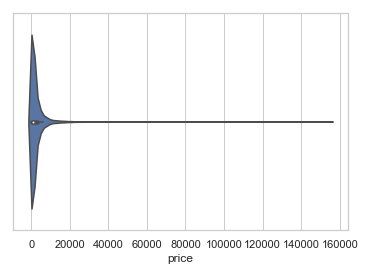

In [9]:
sns.violinplot(x=data["price"])
plt.show()

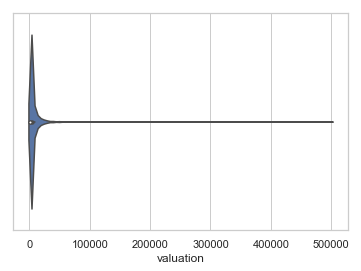

In [10]:
sns.violinplot(x=data["valuation"])
plt.show()

Most of the products are realtively low priced products, and then there are som outliers. Maybe we could restrain the input to products only in a smaller range of prices. That also means we would only build an application for relatively low priced products

#### Creating a scatter plot

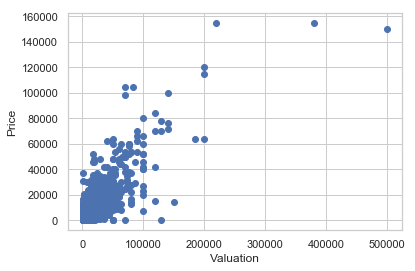

In [11]:
plt.scatter(data['valuation'], data['price'])
plt.xlabel('Valuation')
plt.ylabel('Price')
plt.show()

## Restraining input based on valuation

In [12]:
data_ir = data[data['valuation'] <= 25000]

We are removing all products that have a larger valuation than the defined amount. You are welcome to play around with it

## Restraining output

In [13]:
data_ir = data_ir[data_ir['price'] > 0]

By restraining the output we remove products that are not market fit - Meaning they have no value

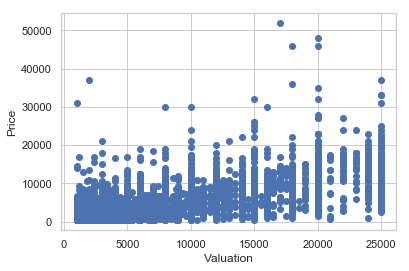

In [14]:
plt.scatter(data_ir['valuation'], data_ir['price'])
plt.xlabel('Valuation')
plt.ylabel('Price')
plt.show()

### Check the data again to see the impact of restraining the input

In [15]:
data_ir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20838 entries, 0 to 22551
Columns: 107 entries, aegte-taepper to wellness
dtypes: float64(106), int64(1)
memory usage: 17.2 MB


In [16]:
data_ir[['valuation', 'price']].describe()

,valuation,price
count,20838.000000,20838.000000
mean,3619.603609,2272.832086
std,4287.719796,3017.217834
min,1000.000000,300.000000
25%,1000.000000,550.000000
50%,1800.000000,1200.000000
75%,4000.000000,2800.000000
max,25000.000000,52000.000000


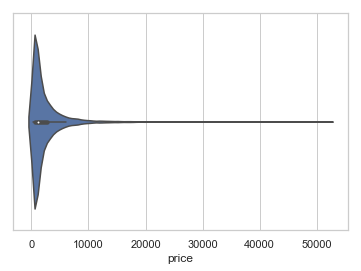

In [17]:
sns.violinplot(x=data_ir["price"])
plt.show()

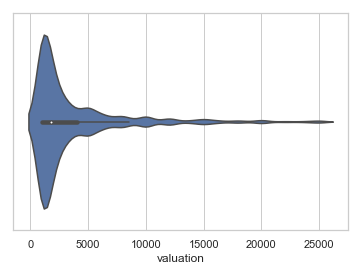

In [18]:
sns.violinplot(x=data_ir["valuation"])
plt.show()

What does the pictures tell you? If you have restrained input like me on 25.000 DKK for valuations, then there are some discrepenacy between the valuation and the sales price. It tells us that some products are valued a great deal lower than the actual sales price. So is the valuation really a good predictor for sales prices at all?

### Checking the correlation coefficient between price and valuation

In [19]:
np.corrcoef(data_ir[['price', 'valuation']], rowvar=False)[0,1]

0.784041979031462

Pretty high correlation of 78 pct. This serves as evidence that the valuation turns out to be a great predictor. Keep in mind that this will probably change as you change the input restrictions

### How about the distribution of the product categories?

In Neural nets you tend to like that each instance is represented more than a few times in order to substantiate a pattern. Therefore we should delete product categories if they are represented less than 10 times just to be sure. Also this is a hyperparameter as well. You can play with it

In [20]:
for col in data_ir.columns:
    if data_ir[col].sum() < 10:
        print('Removing column %s that only occurs %i times' %(col, data_ir[col].sum()))
        data_ir = data_ir[data_ir[col] != 1]
        data_ir = data_ir.drop(col, axis=1)

Removing column biler-baade that only occurs 5 times
Removing column boernetoej that only occurs 1 times
Removing column boligtekstiler that only occurs 4 times
Removing column camping-friluftsliv that only occurs 2 times
Removing column fiskeri that only occurs 6 times
Removing column rideudstyr that only occurs 4 times
Removing column ryataepper that only occurs 2 times
Removing column telefoner-mobiler that only occurs 5 times
Removing column vaegtaepper that only occurs 2 times
Removing column wellness that only occurs 4 times


In [21]:
data_ir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20803 entries, 0 to 22551
Data columns (total 97 columns):
aegte-taepper                        20803 non-null float64
aeldre-billedkunst                   20803 non-null float64
aeldre-og-antikke-taepper            20803 non-null float64
armbaand                             20803 non-null float64
bad                                  20803 non-null float64
blankvaaben                          20803 non-null float64
boeger-kort-blade                    20803 non-null float64
boernemoebler                        20803 non-null float64
bolig                                20803 non-null float64
bordlamper                           20803 non-null float64
bordure                              20803 non-null float64
braendeovne-pejse                    20803 non-null float64
brocher                              20803 non-null float64
bronze-kobber-messing-tin            20803 non-null float64
computere-printere-tilbehoer         20803 non-null

### Split the data for Cross validation purposes

In [22]:
train, test = train_test_split(data_ir, test_size=0.3, random_state=RANDOM_SEED)

We are splliting the data in order to validate the model based on unseen data or test data. We split the data into a training and a test set for now. Keras will independently split the training data into a training and validation set. That means we train the model on the training data, optimize the model weights on the validation data, and finally test the model on the test data. 

## Creating a Keras NN 

#### Initlizing the graph

In [23]:
graph = Sequential()

If you are familiar with tensorflow then you have probably heard the word 'Graph' a few times. Sequential is like initliazing this graph. Its basically like defining something with an empty piece of paper. Its has restrains in the form of edges, but it contains nothing. The graph still doesn't know how many input features we add to it, the structure of the hidden layers or how many dimensions the output layer will have.

#### Creating a hidden layer 

In [24]:
nodesHidden1 = int((len(train.drop('price', axis=1).T) + 1 ))
graph.add(Dense(units=nodesHidden1, kernel_initializer="uniform", \
#                 kernel_regularizer=regularizers.l2(0.01), \
#                 activity_regularizer=regularizers.l1(0.01), \
                activation='relu', input_shape = (len(train.drop('price', axis=1).T), ))) 

When we add layers to our graph, then we draw connections between each layer node. These connections are often referred to as weights. When adding a layer we need to define layer dimensions (nodes or neurons), the activation function and what the dimensions of the prior layer is. Play around with the activation function

#### Adding dropout to prevet overfitting

In [25]:
# drop_rate = 0.25
# graph.add(Dropout(drop_rate))

Dropout is a way to prevent overfitting. It randomly drops nodes/neurons from the graph, so the graph wont generalize to the training data.

#### Adding the output layer

In [26]:
graph.add(Dense(units=1, kernel_initializer='uniform'))

Since we are dealing with a one-dimensiaonal output, which is the case in regression problems, then we only define one output dimension. Had we been dealing with a classification problem we would define the dimensions by number of categories minus 1

#### Compiling the graph

In [27]:
graph.compile(optimizer='adam', loss='mean_squared_error')

Compiling basically tells the graph to close for any new layers, defines the optimizing algorithm and defines the metric in which we want to measure our results. We are using ADAM optimizer, but without defining the parameters of the optimization. But you can play around with this as well.

#### Using Early stopping

In [28]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
callbacks_list = [earlystop] #never figured out why it needs to be changed to a list

We use early stopping because we dont want to keep training our graph whn there are no advantage to gain. The import keyword here is 'patience'. It tells the graph how many times it should train without improving before stopping.

#### Fitting the model

When fitting the model, then it takes the input, the ouput and a the batch (number of rows) that we want to train on at a time. Th epocs are the maximum number of training iterations, and the validion split defines the validation set size. Remember the vcalidation is for measuring improvements during each training iteration. 

In [29]:
trainingHist = graph.fit(train.drop('price', axis=1).values, train['price'].values, \
          batch_size=50, epochs=500, callbacks=callbacks_list, validation_split=0.1)   

Train on 13105 samples, validate on 1457 samples
Epoch 1/500
13105/13105 [==============================] - 1s 108us/step - loss: 5664892.0389 - val_loss: 3480839.9025
Epoch 2/500
13105/13105 [==============================] - 0s 34us/step - loss: 3567193.0699 - val_loss: 3469455.8702
Epoch 3/500
13105/13105 [==============================] - 0s 36us/step - loss: 3568929.2973 - val_loss: 3637099.4823
Epoch 4/500
13105/13105 [==============================] - 0s 35us/step - loss: 3562463.9502 - val_loss: 3478607.5730
Epoch 5/500
13105/13105 [==============================] - 0s 35us/step - loss: 3572892.6651 - val_loss: 3474692.3173
Epoch 00005: early stopping


In [30]:
# plot_model(graph, to_file='graph.png', show_shapes=True)
# Image('graph.png')

dict_keys(['val_loss', 'loss'])


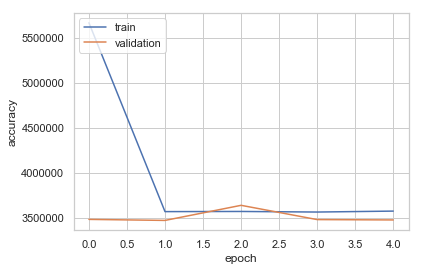

In [31]:
print(trainingHist.history.keys())
# summarize history for accuracy
plt.plot(trainingHist.history['loss'])
plt.plot(trainingHist.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Measuring the performance of the graph

Firstly, we calculate the predictions based on the training and test data

In [32]:
y_pred_test = graph.predict(test.drop('price', axis=1).values)
y_pred_train = graph.predict(train.drop('price', axis=1).values)

Secondly, we calculate some scoring statistics. We use root mean squared error and the explained variation (R²)

In [33]:
meanPriceArray = np.ones(len(train)) * train['price'].mean()

In [37]:
rmseBenchmark = np.sqrt(mean_squared_error(y_true = train['price'].values, y_pred = meanPriceArray))
rmseTrain = np.sqrt(mean_squared_error(y_true = train['price'].values, y_pred = y_pred_train))
rmseTest = np.sqrt(mean_squared_error(y_true = test['price'].values, y_pred = y_pred_test))

In [38]:
accuraciesBenchmark = r2_score(y_true = train['price'].values, y_pred = meanPriceArray)
accuraciesTest = r2_score(y_true = test['price'].values, y_pred = y_pred_test)
accuraciesTrain = r2_score(y_true = train['price'].values, y_pred = y_pred_train)

Thirdly, we print the scores to check performance and the fitting of the graph

In [39]:
print('\n------------------------------------')
print('\nAccuracy benchmark: ', round(accuraciesBenchmark, 2))
print('\nRMSE benchmark: ', round(rmseBenchmark, 2))
print('\n------------------------------------')
print('\nAccuracy train: ', round(accuraciesTrain,2))
print('\nRMSE train: ', round(rmseTrain, 2))
print('\n------------------------------------')
print('\nAccuracy test: ', round(accuraciesTest, 2))
print('\nRMSE test: ', round(rmseTest, 2))
print('\n------------------------------------')


------------------------------------

Accuracy benchmark:  0.01

RMSE benchmark:  3019.03

------------------------------------

Accuracy train:  0.61

RMSE train:  1884.01

------------------------------------

Accuracy test:  0.6

RMSE test:  1889.47

------------------------------------


How did we do? And can you improve our results? How would you deal with the overfitting, if any?

### Predict from new data

In [40]:
list(data_ir.drop(['price', 'valuation'], axis=1).columns)

['aegte-taepper',
 'aeldre-billedkunst',
 'aeldre-og-antikke-taepper',
 'armbaand',
 'bad',
 'blankvaaben',
 'boeger-kort-blade',
 'boernemoebler',
 'bolig',
 'bordlamper',
 'bordure',
 'braendeovne-pejse',
 'brocher',
 'bronze-kobber-messing-tin',
 'computere-printere-tilbehoer',
 'cykler',
 'dametoej',
 'dameure',
 'diamanter-aedelsten',
 'drikkeglas',
 'etnografica',
 'ferielejligheder-sommerhuse',
 'figurer',
 'frimaerker',
 'grafik-og-fotografi',
 'gulvlamper',
 'halskaeder-vedhaeng',
 'have',
 'havemoebler',
 'herretoej',
 'herreure',
 'hifi-stereoanlaeg',
 'hoejttalere-surround-sound',
 'hotel-slot-og-kroophold',
 'jagttrofaeer',
 'jagtudstyr',
 'kameraer-fotoudstyr',
 'kelim',
 'koekken',
 'kontormoebler',
 'laenestole',
 'legetoej',
 'loftslamper',
 'lommeure',
 'maritime-effekter',
 'markiser-solpaneler',
 'militaria-og-samlervaaben',
 'moderne-billedkunst',
 'moderne-taepper',
 'moenter-sedler-og-barrer',
 'musik-musikinstrumenter',
 'oereringe',
 'oevrig-billedkunst-og-skul

In [94]:
newData = [5000, 'ringe']
def predictNew(graph, newData, testdata):
    testdata = testdata.drop('price', axis=1)
    datarow = testdata.iloc[-2:, :]
    datarow.loc[:] = 0
    datarow['valuation'] = newData[0]
    for col in test.columns:
        if newData[1] == col:
            datarow[col] = 1
    return round(graph.predict(datarow.values)[0].item(), 2)
    
    

In [95]:
predictNew(graph, newData, test)

2965.6